In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from collections import Counter

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", 1000)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    StratifiedKFold,
    train_test_split,
    validation_curve,
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost.sklearn import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={"figure.figsize":(15,7)}, style="whitegrid")

In [2]:
DATA_PATH = "data/"
TRAIN_FEATURES = os.path.join(DATA_PATH, "train_new_features.csv")

In [3]:
train_df = pd.read_csv(TRAIN_FEATURES, index_col=0, encoding="utf-8")

In [4]:
train_df.head(2)

,text,target,text_cleaned,preprocessed_text,sentence_count,word_count,stop_word_count,stop_word_share,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,polarity_raw,subjectivity_raw,unique_word_count,unique_word_share,polarity,subjectivity,DT,NN,PRP$,NNS,VBP,IN,MD,VB,JJ,PRP,JJS,VBN,VBD,TO,VBG,CC,RB,EX,VBZ,CD,WP,RP,JJR,WRB,FW,WDT,NNP,RBR,RBS,PDT,SYM,UH,WP$
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all,deed reason earthquake allah forgive,1,13,6,0.461538,0,4.384615,69,1,1,0,0.0,0.0,5,1.0,0.0,0.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada,1,7,0,0.000000,0,4.571429,38,1,0,0,0.1,0.4,7,1.0,0.1,0.4,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data preparation

We can drop features that we selected before.
Features that are linearly dependent might have caused troubles in training linear models such as Logistic Regression.

In [5]:
drop_low_varience = [
    "SYM",
    "WP$",
    "UH",
    "FW",
    "RBS",
    "NNP",
    "sentence_count",
    "unique_word_share",
    "EX",
    "punctuation_count",
    "WP",
    "CD",
    "PRP$",
    "hashtag_count",
    "mention_count",
]
drop_high_corr = ["char_count", "stop_word_count", "unique_word_count"]

In [6]:
train_df.drop(["text", "text_cleaned", "preprocessed_text"], axis=1, inplace=True)
train_df.drop(drop_low_varience, axis=1, inplace=True)
train_df.drop(drop_high_corr, axis=1, inplace=True)

print("Number of columns in train set: {}".format(len(list(train_df))))

Number of columns in train set: 32


In [7]:
if train_df.isnull().any().any():
    print("Found missing values in data")
else:
    print("No missing values in data")

No missing values in data


In [8]:
train = train_df.drop("target", axis=1)
y = train_df["target"]
X_train, X_test, y_train, y_test = train_test_split(
    train, y, test_size=0.3, random_state=13, stratify=y
)

In [9]:
X_train.shape, X_test.shape

((5264, 31), (2256, 31))

In [10]:
sc = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled.loc[:, list(X_train_scaled)] = sc.fit_transform(
    X_train_scaled[list(X_train_scaled)]
)
X_test_scaled = X_test.copy()
X_test_scaled.loc[:, list(X_test_scaled)] = sc.transform(
    X_test_scaled[list(X_test_scaled)]
)

## Approaches
 - linear model (Logistic Regression),
 - boosting (XGBoost)

**Define evaluation procedure.**

We will use repeated cross-validation to evaluate the model, with 5-fold cross-validation.

In [11]:
kf = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)

**Define functions for reports with numbers and plots.**

```The leaderboard is based on Mean F-Score which can be implemented with Macro Average F1 Score.```

In [12]:
def plot_cv_with_err(model, data_X, data_y, parameter_name, params, cv_score, **kwargs):

    """Plot results of cv_output_all"""

    val_train, val_test = validation_curve(
        model,
        data_X,
        data_y,
        param_name=parameter_name,
        param_range=params,
        cv=kf,
        scoring=cv_score,
    )

    means_train = np.mean(val_train, axis=1)
    stds_train = np.std(val_train, axis=1)
    means_test = np.mean(val_test, axis=1)
    stds_test = np.std(val_test, axis=1)

    lines_train = plt.plot(
        params, means_train, "-", label="CV training scores on train set", **kwargs
    )
    lines_test = plt.plot(
        params, means_test, "-", label="CV validation scores on train set", **kwargs
    )

    plt.fill_between(
        params,
        means_train - stds_train,
        means_train + stds_train,
        edgecolor="none",
        facecolor=lines_train[0].get_color(),
        alpha=0.2,
    )
    plt.fill_between(
        params,
        means_test - stds_test,
        means_test + stds_test,
        edgecolor="none",
        facecolor=lines_test[0].get_color(),
        alpha=0.2,
    )

In [13]:
def cv_output_all(model, data_X, data_y, parameter_name, params, cv_score):

    """Same as plot_cv_with_err"""

    val_train, val_test = validation_curve(
        model,
        data_X,
        data_y,
        param_name=parameter_name,
        param_range=params,
        cv=kf,
        scoring=cv_score,
    )
    means_train = np.mean(val_train, axis=1)
    stds_train = np.std(val_train, axis=1)
    means_test = np.mean(val_test, axis=1)
    stds_test = np.std(val_test, axis=1)

    print("                                    CV scores on Train set")
    print(
        "================================================================================================"
    )
    print(
        "  mean_train_score (std_train_score) | mean_valid_score (std_valid_score) |      parameter"
    )
    print(
        "================================================================================================"
    )
    for mean_tr, stdev_tr, mean_te, stdev_te, param in zip(
        means_train, stds_train, means_test, stds_test, params
    ):
        print(
            "    {:^{width}.{prec}}  ({:^{width}.{prec}}) |   {:^{width}.{prec}}  ({:^{width}.{prec}}) | {:{align}} = {:{align}.{prec}}".format(
                mean_tr,
                stdev_tr,
                mean_te,
                stdev_te,
                parameter_name,
                param,
                align="<",
                width="14",
                prec=5,
            )
        )

## Logistic Regression

### Baseline model.

**Define model.**

In [14]:
lr = LogisticRegression(
    solver="liblinear", penalty="l2", C=1e5, class_weight="balanced", random_state=13
)

In [15]:
lr.fit(X_train_scaled, y_train)

LogisticRegression(C=100000.0, class_weight='balanced', random_state=13,
                   solver='liblinear')

**Evaluate model, establish a baseline.**

In [16]:
print(
    "f1_score (train set): {:.5}".format(
        f1_score(y_train, lr.predict(X_train_scaled), average="macro")
    )
)

print(
    "\nf1_score (test set):  {:.5}".format(
        f1_score(y_test, lr.predict(X_test_scaled), average="macro")
    )
)

f1_score (train set): 0.67459

f1_score (test set):  0.64585


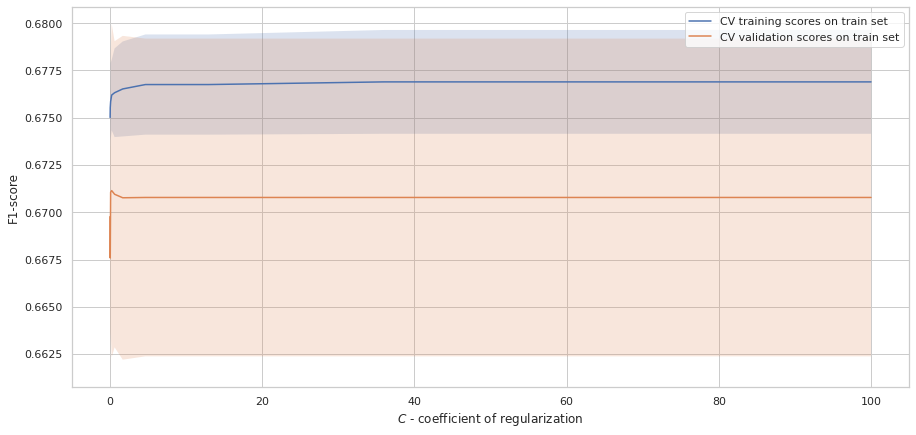

In [17]:
plot_cv_with_err(
    model=lr,
    data_X=X_train_scaled,
    data_y=y_train,
    parameter_name="C",
    params=np.logspace(-2, 2, 10),
    cv_score="f1_macro",
)

plt.xlabel("$C$ - coefficient of regularization")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.grid(True)

### Hyperparameter optimization.

In [18]:
lr_1 = LogisticRegression(solver="liblinear", class_weight="balanced", random_state=13)

lr_param_grid_1 = {"penalty": ["l1", "l2"], "C": np.logspace(-2, 2, 10)}

lr_clf_1 = GridSearchCV(
    estimator=lr_1, cv=kf, param_grid=lr_param_grid_1, scoring="f1_macro", verbose=1
)

%time  lr_clf_1.fit(X_train_scaled, y_train)

print(
    "\nBest_params: {}, best_score: {:.5}".format(
        lr_clf_1.best_params_, lr_clf_1.best_score_
    )
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 11.8 s, sys: 452 ms, total: 12.2 s
Wall time: 6.23 s

Best_params: {'C': 0.21544346900318834, 'penalty': 'l2'}, best_score: 0.67115


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.2s finished


In [19]:
lr_2 = LogisticRegression(solver="liblinear", class_weight="balanced", random_state=13)

lr_param_grid_2 = {"penalty": ["l2"], "C": np.linspace(0.001, 10, 40)}

lr_clf_2 = GridSearchCV(
    estimator=lr_2, cv=kf, param_grid=lr_param_grid_2, scoring="f1_macro", verbose=1
)

%time  lr_clf_2.fit(X_train_scaled, y_train)

print(
    "\nBest_params: {}, best_score: {:.5}".format(
        lr_clf_2.best_params_, lr_clf_2.best_score_
    )
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 14.8 s, sys: 472 ms, total: 15.3 s
Wall time: 7.67 s

Best_params: {'C': 0.2573846153846154, 'penalty': 'l2'}, best_score: 0.67153


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.6s finished


### Final model.

In [20]:
lr_final = LogisticRegression(
    C=1.8, penalty="l2", solver="liblinear", class_weight="balanced", random_state=13
)

%time lr_final.fit(X_train_scaled, y_train)

CPU times: user 136 ms, sys: 8.02 ms, total: 144 ms
Wall time: 72.7 ms


LogisticRegression(C=1.8, class_weight='balanced', random_state=13,
                   solver='liblinear')

**Evaluate model.**

In [21]:
print(
    "f1_score (train set): {:.5}".format(
        f1_score(y_train, lr_final.predict(X_train_scaled), average="macro")
    )
)

print(
    "\nf1_score (test set):  {:.5}".format(
        f1_score(y_test, lr_final.predict(X_test_scaled), average="macro")
    )
)

f1_score (train set): 0.67476

f1_score (test set):  0.64542


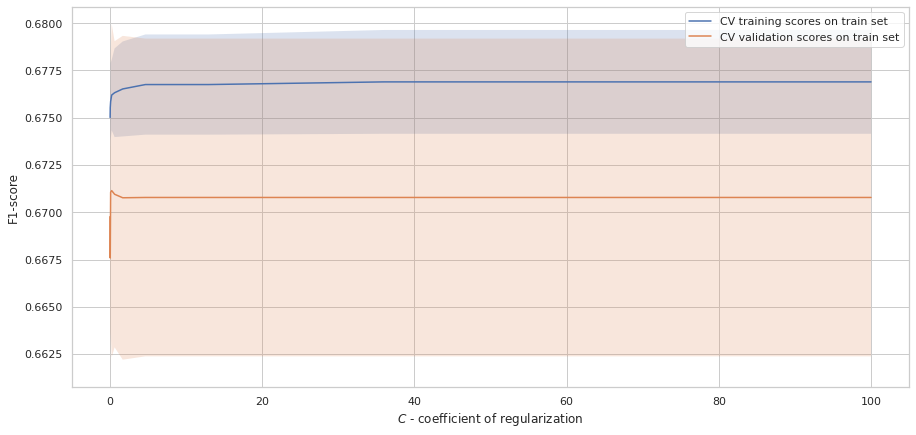

In [22]:
plot_cv_with_err(
    model=lr_final,
    data_X=X_train_scaled,
    data_y=y_train,
    parameter_name="C",
    params=np.logspace(-2, 2, 10),
    cv_score="f1_macro",
)

plt.xlabel("$C$ - coefficient of regularization")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.grid(True)

The trend is quite visible.

Training and validation errors differ significantly. This can be explained by **overfitting**. When there are too many parameters or regularization is not strict enough, the algorithm can be "distracted" by the noise in the data and lose track of the overall trend.

Our model tend to be overfitted.

In [23]:
cv_output_all(
    model=lr_final,
    data_X=X_train_scaled,
    data_y=y_train,
    parameter_name="C",
    params=np.linspace(0.001, 5, 40),
    cv_score="f1_macro",
)

                                    CV scores on Train set
  mean_train_score (std_train_score) | mean_valid_score (std_valid_score) |      parameter
       0.67152      (   0.001734   ) |      0.66919      (   0.006967   ) | C = 0.001
       0.67614      (  0.0019721   ) |      0.67101      (  0.0081786   ) | C = 0.12918
        0.6761      (  0.0020126   ) |      0.67153      (  0.0088489   ) | C = 0.25736
       0.67648      (    0.0023    ) |      0.67039      (  0.0085871   ) | C = 0.38554
       0.67628      (  0.0022031   ) |      0.67093      (  0.0083304   ) | C = 0.51372
       0.67642      (  0.0022355   ) |      0.67095      (   0.008097   ) | C = 0.6419
       0.67633      (  0.0021838   ) |      0.67077      (  0.0083319   ) | C = 0.77008
       0.67633      (  0.0020785   ) |      0.67113      (  0.0081857   ) | C = 0.89826
       0.67638      (  0.0022368   ) |      0.67095      (  0.0084221   ) | C = 1.0264
       0.67638      (   0.002293   ) |      0.67059      (  0.

## XGBoost Classifier

### Baseline model.

Before any modification or tuning is made to the XGBoost algorithm for imbalanced classification, it is important to test the default XGBoost model and **establish a baseline in performance**.

**Define model.**

In [24]:
xgb = XGBClassifier(objective="binary:logistic", booster="gbtree", random_state=13)

**Fit model (optimize model loss function).**

In [25]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=13,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Evaluate model, establish a baseline.**

In [26]:
print(
    "f1_score (train set): {:.5}".format(
        f1_score(y_train, xgb.predict(X_train), average="macro")
    )
)

print(
    "\nf1_score (test set):  {:.5}".format(
        f1_score(y_test, xgb.predict(X_test), average="macro")
    )
)

f1_score (train set): 0.94174

f1_score (test set):  0.68562


### Hyperparameter optimization.

**Imbalanced Classification.**

The *scale_pos_weight* can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.

- scale_pos_weight = total_negative_examples / total_positive_examples

In [27]:
counter = Counter(y_train)
estimate = counter[0] / counter[1]
print("scale_pos_weight: %.3f" % estimate)

scale_pos_weight: 1.336


In [28]:
xgb_1 = XGBClassifier(
    scale_pos_weight=1.336,
    learning_rate=0.3,
    max_depth=8,
    min_child_weight=94,
    gamma=0.1,
    colsample_bytree=0.55,
    subsample=0.9,
    reg_alpha=1e-05,
    reg_lambda=1,
    objective="binary:logistic",
    booster="gbtree",
    random_state=13,
)

xgb_1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.55, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=94, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=13,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1.336,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [29]:
print(
    "f1_score (train set): {:.5}".format(
        f1_score(y_train, xgb_1.predict(X_train), average="macro")
    )
)

print(
    "\nf1_score (test set):  {:.5}".format(
        f1_score(y_test, xgb_1.predict(X_test), average="macro")
    )
)

f1_score (train set): 0.74918

f1_score (test set):  0.68072


**Early Stopping to Avoid Overfitting.**

It avoids overfitting by attempting to automatically select the inflection point where **performance on the test dataset starts to decrease** while **performance on the training dataset continues to improve** as the model starts to overfit.

In [30]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.33, random_state=7
)

xgb_2 = XGBClassifier(
    scale_pos_weight=1.336,
    learning_rate=0.3,
    max_depth=8,
    min_child_weight=94,
    gamma=0.1,
    colsample_bytree=0.55,
    subsample=0.9,
    reg_alpha=1e-05,
    reg_lambda=1,
    objective="binary:logistic",
    booster="gbtree",
    random_state=13,
)

eval_set = [(X_tr, y_tr), (X_val, y_val)]

xgb_2.fit(X_tr, y_tr, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.37635	validation_0-logloss:0.67136	validation_1-error:0.36364	validation_1-logloss:0.66813
[1]	validation_0-error:0.34260	validation_0-logloss:0.65068	validation_1-error:0.34695	validation_1-logloss:0.64620
[2]	validation_0-error:0.33721	validation_0-logloss:0.63848	validation_1-error:0.32739	validation_1-logloss:0.63184
[3]	validation_0-error:0.32303	validation_0-logloss:0.62474	validation_1-error:0.31876	validation_1-logloss:0.61864
[4]	validation_0-error:0.31764	validation_0-logloss:0.61590	validation_1-error:0.30898	validation_1-logloss:0.60975
[5]	validation_0-error:0.31509	validation_0-logloss:0.60944	validation_1-error:0.30610	validation_1-logloss:0.60520
[6]	validation_0-error:0.31622	validation_0-logloss:0.60529	validation_1-error:0.30898	validation_1-logloss:0.60024
[7]	validation_0-error:0.31452	validation_0-logloss:0.60138	validation_1-error:0.30840	validation_1-logloss:0.59984
[8]	validation_0-error:0.31424	validation_0-logloss:0.59833	validation_1

[71]	validation_0-error:0.27709	validation_0-logloss:0.54756	validation_1-error:0.31243	validation_1-logloss:0.58861
[72]	validation_0-error:0.27567	validation_0-logloss:0.54724	validation_1-error:0.31128	validation_1-logloss:0.58878
[73]	validation_0-error:0.27595	validation_0-logloss:0.54684	validation_1-error:0.31646	validation_1-logloss:0.58917
[74]	validation_0-error:0.27709	validation_0-logloss:0.54610	validation_1-error:0.31185	validation_1-logloss:0.58849
[75]	validation_0-error:0.27623	validation_0-logloss:0.54566	validation_1-error:0.31415	validation_1-logloss:0.58860
[76]	validation_0-error:0.27425	validation_0-logloss:0.54525	validation_1-error:0.31358	validation_1-logloss:0.58766
[77]	validation_0-error:0.27567	validation_0-logloss:0.54514	validation_1-error:0.31300	validation_1-logloss:0.58751
[78]	validation_0-error:0.27453	validation_0-logloss:0.54475	validation_1-error:0.31128	validation_1-logloss:0.58812
[79]	validation_0-error:0.27709	validation_0-logloss:0.54478	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.55, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=94, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=13,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1.336,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

By default for XGBClassifier *eval_metric = 'error'*.

In [31]:
print(
    "f1_score (train set): {:.5}".format(
        f1_score(y_train, xgb_2.predict(X_train), average="macro")
    )
)

print(
    "\nf1_score (test set):  {:.5}".format(
        f1_score(y_test, xgb_2.predict(X_test), average="macro")
    )
)

f1_score (train set): 0.71373

f1_score (test set):  0.6668


**Plot performance metrics.**

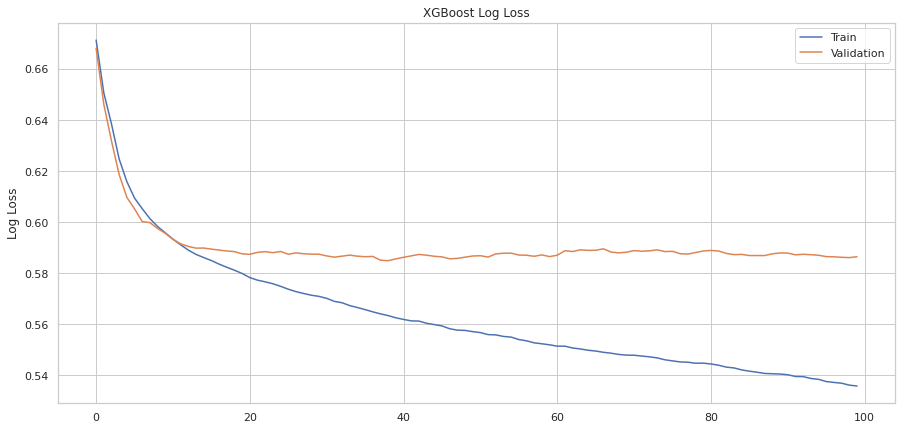

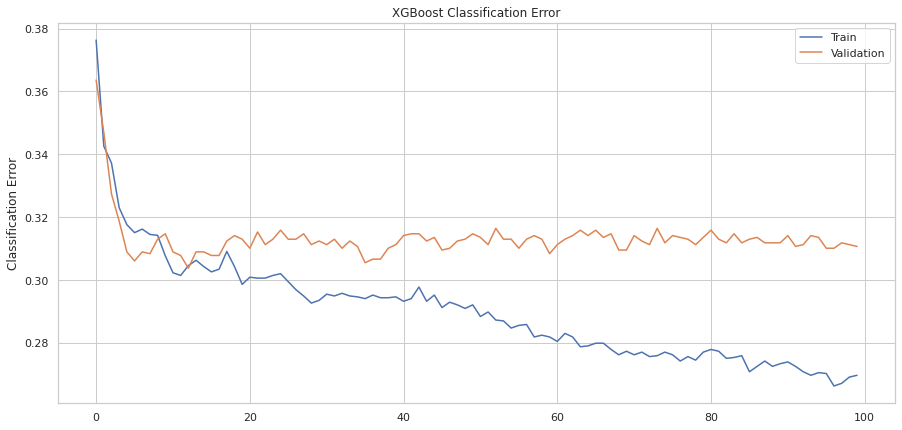

In [32]:
results = xgb_2.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Validation")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Validation")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

The first plot shows the logarithmic loss of the XGBoost model for each epoch on the training and test datasets.

The second plot shows the classification error of the XGBoost model for each epoch on the training and test datasets.

From reviewing the logloss plot, it looks like there is an opportunity to stop the learning early, perhaps somewhere around epoch 80 to epoch 100.

We see a similar story for classification error, where error appears to go back up at around epoch 30.

### Final model.

In [33]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.33, random_state=13
)

xgb_final = XGBClassifier(
    scale_pos_weight=1.336,
    learning_rate=0.3,
    max_depth=8,
    min_child_weight=94,
    gamma=0.1,
    colsample_bytree=0.55,
    subsample=0.9,
    reg_alpha=1e-05,
    reg_lambda=1,
    objective="binary:logistic",
    booster="gbtree",
    random_state=13,
)

eval_set = [(X_val, y_val)]
xgb_final.fit(
    X_tr,
    y_tr,
    early_stopping_rounds=10,
    eval_metric="error",
    eval_set=eval_set,
    verbose=True,
)

[0]	validation_0-error:0.38262
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.33487
[2]	validation_0-error:0.34120
[3]	validation_0-error:0.32739
[4]	validation_0-error:0.31818
[5]	validation_0-error:0.31761
[6]	validation_0-error:0.31473
[7]	validation_0-error:0.31761
[8]	validation_0-error:0.31473
[9]	validation_0-error:0.31818
[10]	validation_0-error:0.31243
[11]	validation_0-error:0.31415
[12]	validation_0-error:0.31415
[13]	validation_0-error:0.31300
[14]	validation_0-error:0.31531
[15]	validation_0-error:0.31473
[16]	validation_0-error:0.31646
[17]	validation_0-error:0.31876
[18]	validation_0-error:0.31646
[19]	validation_0-error:0.32106
[20]	validation_0-error:0.32394
Stopping. Best iteration:
[10]	validation_0-error:0.31243



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.55, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=94, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=13,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1.336,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

**Evaluate model.**

In [34]:
print(
    "f1_score (train set): {:.5}".format(
        f1_score(y_train, xgb_final.predict(X_train), average="macro")
    )
)

print(
    "\nf1_score (test set):  {:.5}".format(
        f1_score(y_test, xgb_final.predict(X_test), average="macro")
    )
)

f1_score (train set): 0.68599

f1_score (test set):  0.67301


We can see that **the model stopped training at epoch 36** (close to what we expected by our manual judgment of learning curves) and that the model with **the best loss was observed at epoch 26**.

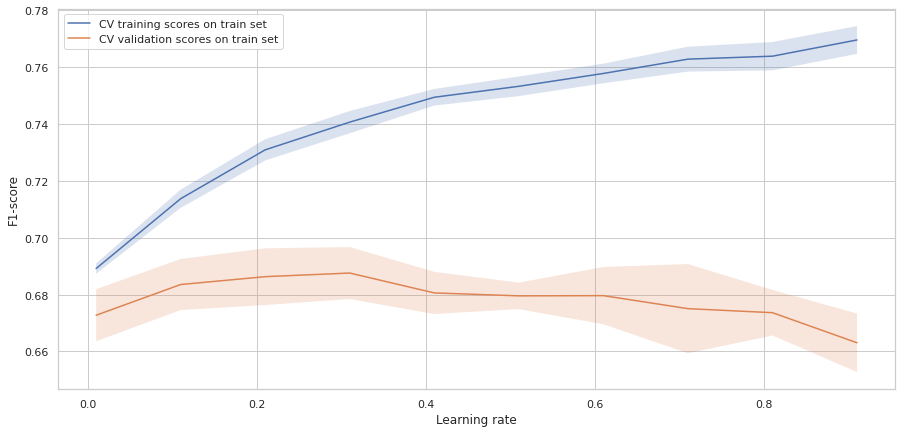

In [35]:
plot_cv_with_err(
    model=xgb_final,
    data_X=X_train,
    data_y=y_train,
    parameter_name="learning_rate",
    params=[i / 100.0 for i in range(1, 101, 10)],
    cv_score="f1_macro",
)

plt.xlabel("Learning rate")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.grid(True)

In [36]:
cv_output_all(
    model=xgb_final,
    data_X=X_train,
    data_y=y_train,
    parameter_name="learning_rate",
    params=[i / 100.0 for i in range(1, 101, 10)],
    cv_score="f1_macro",
)

                                    CV scores on Train set
  mean_train_score (std_train_score) | mean_valid_score (std_valid_score) |      parameter
       0.68918      (  0.0018335   ) |      0.67274      (  0.0091582   ) | learning_rate = 0.01
       0.71372      (  0.0032078   ) |      0.68354      (  0.0089775   ) | learning_rate = 0.11
       0.73092      (  0.0037325   ) |      0.68631      (  0.0099689   ) | learning_rate = 0.21
       0.74067      (   0.003925   ) |      0.68758      (  0.0091416   ) | learning_rate = 0.31
       0.74941      (  0.0029172   ) |      0.68059      (  0.0074207   ) | learning_rate = 0.41
       0.75326      (  0.0034518   ) |      0.67955      (  0.0046495   ) | learning_rate = 0.51
       0.75778      (  0.0034491   ) |      0.67964      (   0.010078   ) | learning_rate = 0.61
       0.76281      (  0.0043786   ) |      0.67506      (   0.015686   ) | learning_rate = 0.71
       0.76385      (  0.0049964   ) |      0.67364      (  0.0080173   ) 

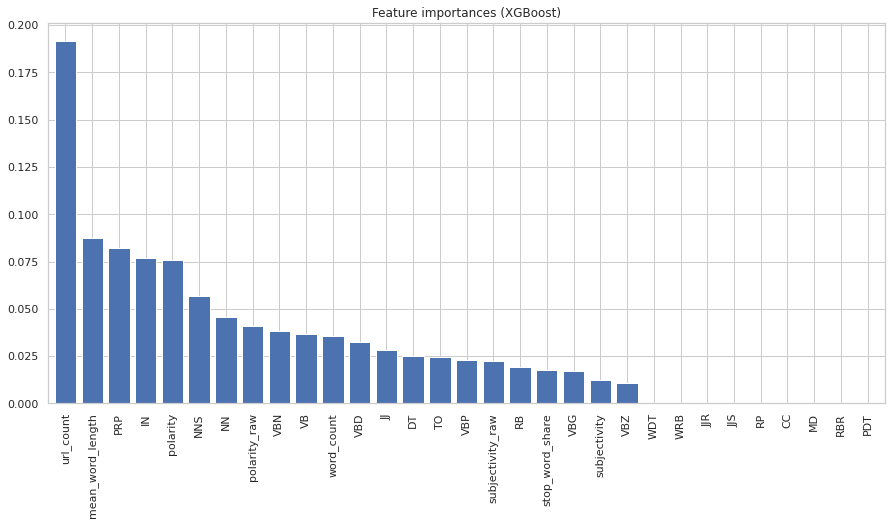

In [37]:
fi = pd.Series(xgb_final.feature_importances_, index=X_train.columns)
fi.sort_values(ascending=False).plot(kind="bar", width=0.8)
plt.title("Feature importances (XGBoost)")
plt.show()

## Results

In [38]:
def get_scores(estimator, X, y, name):
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    columns = ["accuracy", "precision", "recall", "F1-macro", "AUC-ROC"]
    results = pd.DataFrame(
        [accuracy, precision, recall, f1, roc_auc], index=columns, columns=[name]
    ).T

    return results

In [39]:
results_lr = get_scores(lr_final, X=X_test_scaled, y=y_test, name="LR")
results_xgb = get_scores(xgb_final, X=X_test, y=y_test, name="XGB")

In [40]:
results_lr.append(results_xgb)

,accuracy,precision,recall,F1-macro,AUC-ROC
LR,0.647163,0.574581,0.674611,0.645424,0.710652
XGB,0.675975,0.608736,0.678756,0.673005,0.729693


## Conclusions

1. Logistic Regression and XGBoost machine learning models with tuned hyperparameters were applied to the tabular data.